# DNN_PAPER_V1

## Import & Helperfunctions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
import math
import uuid

/home/spokencall/.conda/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/spokencall/.conda/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def clearY(y):
    clean_input = np.array([]).reshape(0, 1)
    for data in y:
        pos1 = data[0]
        pos2 = data[1]
        pos3 = data[2]
        if  pos1 == 1 and pos2 == 0 and pos3 ==0:
                clean_input = np.vstack((clean_input, [1]))
        else:
                clean_input = np.vstack((clean_input, [0]))
    return clean_input

In [3]:
def evaluate(true_y, pred_y):
    true_classes = []
    for array in true_y:
        if np.array_equal(array,[1, 0, 0]):
            true_classes.append(0)
        elif np.array_equal(array,[0, 1, 0]):
            true_classes.append(1)
        else:
            true_classes.append(2)
        
    CR, CA, PFA, GFA, FR, k = 0, 0, 0, 0, 0, 3.0
    for idx, prediction in enumerate(pred_y):
        # the students answer is correct in meaning and language
        # the system says the same -> accept
        if true_classes[idx] == 0 and prediction == 1:
            CA += 1
        # the system says correct meaning wrong language -> reject
        elif true_classes[idx] == 0 and prediction == 0:
            FR += 1
        # the system says incorrect meaning and incorrect language -> reject
        elif true_classes[idx] == 0 and prediction == 0:
            FR += 1

        # students answer is correct in meaning and wrong in language
        #The system says the same -> reject
        elif true_classes[idx] == 1 and prediction == 0:
            CR += 1
        # the system says correct meaning and correct language -> accept
        elif true_classes[idx] == 1 and prediction == 1:
            PFA += 1
        # the system says incorrect meaning and incorrect language -> reject
        elif true_classes[idx] == 1 and prediction == 0:
            CR += 1

        # students answer is incorrect in meaning and incorrect in language
        # the system says the same -> reject
        elif true_classes[idx] == 2 and prediction == 0:
            CR += 1
        # the system says correct meaning correct language -> accept
        elif true_classes[idx] == 2 and prediction == 1: 
            GFA += 1
        # the system says correct meaning incorrect language -> reject
        elif true_classes[idx] == 2 and prediction == 0:
            CR += 1

    FA = PFA + k * GFA
    Correct = CA + FR
    Incorrect = CR + GFA + PFA
    IncorrectRejectionRate = CR / ( CR + FA + 0.0 )
    CorrectRejectionRate = FR / ( FR + CA + 0.0 )
    # Further metrics
    Z = CA + CR + FA + FR
    Ca = CA / Z
    Cr = CR / Z
    Fa = FA / Z
    Fr = FR / Z
    
    P = Ca / (Ca + Fa)
    R = Ca / (Ca + Fr)
    SA = Ca + Cr
    F = (2 * P * R)/( P + R)
    
    RCa = Ca / (Fr + Ca)
    RFa = Fa / (Cr + Fa)
    
    D = IncorrectRejectionRate / CorrectRejectionRate
    Da = RCa / RFa
    Df = math.sqrt((Da*D))
    
    print('\nINCORRECT UTTERANCES (' + str(Incorrect) + ')' )
    print('CorrectReject    ' + str(CR) )
    print('GrossFalseAccept ' + str(GFA) + '*' + str(k) + ' = ' + str(GFA * k) )
    print('PlainFalseAccept ' + str(PFA) )
    print('RejectionRate    ' + "{:.3f}".format(IncorrectRejectionRate) )

    print('\nCORRECT UTTERANCES (' + str(Correct) + ')')
    print('CorrectAccept    ' + str(CA) )
    print('FalseReject      ' + str(FR) )
    print('RejectionRate    ' + "{:.3f}".format(CorrectRejectionRate) )
    
    print('\n--------------REPORT---------------')
    print('-----------------------------------')
    print('Pr                            ' +  "{:.3f}".format(P) )
    print('F                             ' +  "{:.3f}".format(F) )
    print('Sa                            ' +  "{:.3f}".format(SA) )
    
    print('\n--------------Metrics--------------')
    print('D                             ' +  "{:.3f}".format(D) )
    print('Da                            ' +  "{:.3f}".format(Da) )
    print('Df                            ' +  "{:.3f}".format(Df) )

## Preprocessing

In [4]:
train_x = np.loadtxt('/home/spokencall/dnnPaper/expValidation/vec_train_x.csv' ,delimiter=',',usecols=range(11)[1:])
train_y = clearY(np.loadtxt('/home/spokencall/dnnPaper/expValidation/vec_train_y.csv', delimiter=',',usecols=range(4)[1:]))

print('Train_x:    ' + str(len(train_x)))
print('Train_y:    ' + str(len(train_y)))

print('\n')


dev_test_x = np.loadtxt('/home/spokencall/dnnPaper/expValidation/vec_test_x.csv', delimiter=',',usecols=range(11)[1:])
dev_test_y = np.loadtxt('/home/spokencall/dnnPaper/expValidation/vec_test_y.csv', delimiter=',',usecols=range(4)[1:])
print('Dev_Test_x:    ' + str(len(dev_test_x)))
print('Dev_Test_y:    ' + str(len(dev_test_y)))

Train_x:    10092
Train_y:    10092


Dev_Test_x:    2524
Dev_Test_y:    2524


In [5]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [6]:
# Sclae the vectors inorder to get better classification
sc = StandardScaler()
scaled_train_x = sc.fit_transform(train_x)
scaled_dev_test_x = sc.transform(dev_test_x)

## DNN definition

In [7]:
#Initializing Neural Network
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(64, activation='relu', input_dim=10))
classifier.add(Dropout(0.5))
classifier.add(Dense(64, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(1, activation='sigmoid'))

In [8]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
classifier.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [9]:
print(classifier.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                704       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________
None


## Training of the model

In [10]:
# Fitting our model 
hist = classifier.fit(scaled_train_x, train_y, batch_size = 5, epochs = 200, validation_split=0.1)

Train on 9082 samples, validate on 1010 samples
Epoch 1/200
9082/9082 [==============================] - 4s 421us/step - loss: 0.4199 - acc: 0.8358 - val_loss: 0.4915 - val_acc: 0.7861
Epoch 2/200
9082/9082 [==============================] - 4s 429us/step - loss: 0.3690 - acc: 0.8694 - val_loss: 0.4774 - val_acc: 0.8376
Epoch 3/200
9082/9082 [==============================] - 4s 427us/step - loss: 0.3571 - acc: 0.8716 - val_loss: 0.4763 - val_acc: 0.7861
Epoch 4/200
9082/9082 [==============================] - 4s 431us/step - loss: 0.3524 - acc: 0.8752 - val_loss: 0.4603 - val_acc: 0.8317
Epoch 5/200
9082/9082 [==============================] - 4s 413us/step - loss: 0.3499 - acc: 0.8748 - val_loss: 0.4533 - val_acc: 0.8337
Epoch 6/200
9082/9082 [==============================] - 4s 424us/step - loss: 0.3420 - acc: 0.8799 - val_loss: 0.4487 - val_acc: 0.8366
Epoch 7/200
9082/9082 [==============================] - 4s 421us/step - loss: 0.3405 - acc: 0.8789 - val_loss: 0.4452 - val_acc: 

9082/9082 [==============================] - 4s 411us/step - loss: 0.3433 - acc: 0.8767 - val_loss: 0.4413 - val_acc: 0.8317
Epoch 61/200
9082/9082 [==============================] - 4s 414us/step - loss: 0.3393 - acc: 0.8795 - val_loss: 0.4937 - val_acc: 0.7832
Epoch 62/200
9082/9082 [==============================] - 4s 409us/step - loss: 0.3397 - acc: 0.8779 - val_loss: 0.4470 - val_acc: 0.8317
Epoch 63/200
9082/9082 [==============================] - 4s 412us/step - loss: 0.3434 - acc: 0.8759 - val_loss: 0.4674 - val_acc: 0.8317
Epoch 64/200
9082/9082 [==============================] - 4s 421us/step - loss: 0.3397 - acc: 0.8787 - val_loss: 0.5163 - val_acc: 0.7832
Epoch 65/200
9082/9082 [==============================] - 4s 418us/step - loss: 0.3385 - acc: 0.8789 - val_loss: 0.4581 - val_acc: 0.8337
Epoch 66/200
9082/9082 [==============================] - 4s 412us/step - loss: 0.3447 - acc: 0.8772 - val_loss: 0.4639 - val_acc: 0.8327
Epoch 67/200
9082/9082 [=======================

9082/9082 [==============================] - 4s 410us/step - loss: 0.3372 - acc: 0.8808 - val_loss: 0.4599 - val_acc: 0.7832
Epoch 120/200
9082/9082 [==============================] - 4s 410us/step - loss: 0.3410 - acc: 0.8782 - val_loss: 0.4561 - val_acc: 0.8317
Epoch 121/200
9082/9082 [==============================] - 4s 415us/step - loss: 0.3352 - acc: 0.8825 - val_loss: 0.4430 - val_acc: 0.8337
Epoch 122/200
9082/9082 [==============================] - 4s 413us/step - loss: 0.3377 - acc: 0.8794 - val_loss: 0.4562 - val_acc: 0.8337
Epoch 123/200
9082/9082 [==============================] - 4s 414us/step - loss: 0.3427 - acc: 0.8755 - val_loss: 0.4488 - val_acc: 0.8337
Epoch 124/200
9082/9082 [==============================] - 4s 426us/step - loss: 0.3369 - acc: 0.8788 - val_loss: 0.4499 - val_acc: 0.8307
Epoch 125/200
9082/9082 [==============================] - 4s 418us/step - loss: 0.3362 - acc: 0.8816 - val_loss: 0.4544 - val_acc: 0.8337
Epoch 126/200
9082/9082 [================

9082/9082 [==============================] - 4s 413us/step - loss: 0.3352 - acc: 0.8810 - val_loss: 0.4975 - val_acc: 0.7851
Epoch 179/200
9082/9082 [==============================] - 4s 406us/step - loss: 0.3353 - acc: 0.8809 - val_loss: 0.4952 - val_acc: 0.7822
Epoch 180/200
9082/9082 [==============================] - 4s 420us/step - loss: 0.3369 - acc: 0.8802 - val_loss: 0.4709 - val_acc: 0.7822
Epoch 181/200
9082/9082 [==============================] - 4s 401us/step - loss: 0.3318 - acc: 0.8838 - val_loss: 0.4640 - val_acc: 0.7812
Epoch 182/200
9082/9082 [==============================] - 4s 414us/step - loss: 0.3320 - acc: 0.8837 - val_loss: 0.4891 - val_acc: 0.7851
Epoch 183/200
9082/9082 [==============================] - 4s 406us/step - loss: 0.3385 - acc: 0.8799 - val_loss: 0.4796 - val_acc: 0.7802
Epoch 184/200
9082/9082 [==============================] - 4s 416us/step - loss: 0.3334 - acc: 0.8836 - val_loss: 0.4513 - val_acc: 0.8337
Epoch 185/200
9082/9082 [================

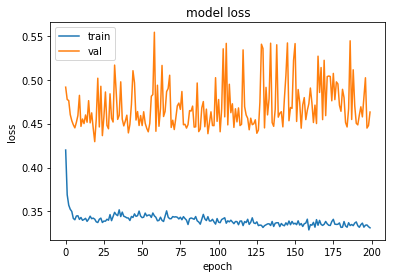

In [11]:
import matplotlib.pyplot as plt
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.savefig("/home/spokencall/dnnPaper/expValidation/accuracy.png")
plt.show()

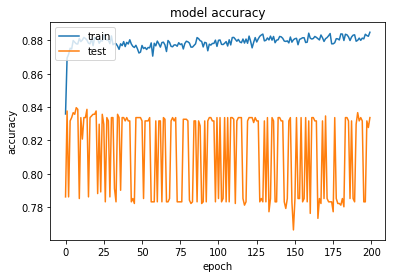

In [12]:
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("/home/spokencall/dnnPaper/expValidation/accuracy.png")
plt.show()

## Save the model

In [13]:
# uniqId
uniqId = uuid.UUID('{00010203-0405-0607-0809-0a0b0c0d0e0f}')
jsonFile = 'v1_model_' + str(uniqId)  +'_.json'
h5File = 'v1_model_' + str(uniqId)  + '_.h5'
# Save the model
model_json = classifier.to_json()
with open(jsonFile, 'w+') as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
classifier.save_weights(h5File)

print("Saved model to disk")
print('model-id:        ' + str(uniqId))
print('json:        ' + str(jsonFile))
print('h5File:        ' + str(h5File))

Saved model to disk
model-id:        00010203-0405-0607-0809-0a0b0c0d0e0f
json:        v1_model_00010203-0405-0607-0809-0a0b0c0d0e0f_.json
h5File:        v1_model_00010203-0405-0607-0809-0a0b0c0d0e0f_.h5


## Evaluation of the model

### Evaluate model with development test data

In [14]:
dev_y_pred = classifier.predict_classes(scaled_dev_test_x)
evaluate(dev_test_y, dev_y_pred)


INCORRECT UTTERANCES (726)
CorrectReject    627
GrossFalseAccept 22*3.0 = 66.0
PlainFalseAccept 77
RejectionRate    0.814

CORRECT UTTERANCES (1798)
CorrectAccept    1624
FalseReject      174
RejectionRate    0.097

--------------REPORT---------------
-----------------------------------
Pr                            0.919
F                             0.911
Sa                            0.877

--------------Metrics--------------
D                             8.414
Da                            4.864
Df                            6.397
